<a href="https://colab.research.google.com/github/rubanzasilva/abalone_age_prediction/blob/dev/ps_s04e04_fastai_exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e4:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F72489%2F8096274%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240417%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240417T100450Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dd8850e4df291eb4b4f408d0aefc6b0e007c89e68c171b2d00d7f59b4ff85998e9a6a0cbff1a9b09dff5c9c0488304cb5e975df90570639cf0e5e6bce2ec123a6772bc5b9e1a14d3e2222d05cfe4c8b102a4878a3428e544230a736d2f379f91b21c59fcfd0d068e59ad9b49dfaff989bbda2a861a52058f4f4e534a08a1379833760585114bf373f4a3393272b181487cbd41ccd876b72190deaca39bac57686d8fee109186f7246150b62973ef5cc1f5fd3e852da3ffa43b6dce938566ed8f2dafb2e59ad9369101f095eda904d6b012a7e685425cb0791e9b19bfd2efb86310d644b553d02dd3ef0c8f30045248f583d52773c4cb92eb8691a0021d616e08a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2529839 bytes downloaded
Downloaded and uncompressed: playground-series-s4e4
Data source import complete.


#### Imports

In [4]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rubanzasilva","key":"66f0a218409548d928d5c5094786660c"}'}

In [6]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [3]:
#set_seed(42)

In [7]:
path = Path('/kaggle/input/playground-series-s4e4/')
path

Path('/kaggle/input/playground-series-s4e4')

In [8]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')

In [9]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

In [10]:
to.xs.iloc[:2]

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
16272,3,1.333980,1.204845,1.428429,1.392082,1.627494,1.197547,0.913851
66481,3,0.066176,-0.018058,-0.799767,0.180150,0.541089,-0.080033,-0.211578


In [8]:
dls = to.dataloaders(bs=64)

In [19]:
dls.show_batch()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,F,0.610,0.460,0.160,1.0265,0.4935,0.2435,0.2565,11.0
1,I,0.580,0.430,0.130,0.7635,0.3620,0.1635,0.1845,10.0
2,I,0.475,0.350,0.125,0.4545,0.2165,0.0925,0.1345,9.0
3,F,0.645,0.510,0.150,1.3725,0.6390,0.3585,0.3800,11.0
4,M,0.580,0.455,0.170,1.0230,0.4355,0.2805,0.2800,15.0
5,M,0.425,0.310,0.095,0.3515,0.1440,0.0725,0.1000,9.0
6,F,0.505,0.390,0.115,0.5470,0.2105,0.1030,0.1590,7.0
7,M,0.675,0.525,0.190,1.6705,0.7295,0.3735,0.4350,10.0
8,M,0.635,0.490,0.175,1.2315,0.5265,0.2865,0.3600,9.0
9,M,0.625,0.480,0.160,1.1115,0.4895,0.2555,0.3325,11.0


In [10]:
learn = tabular_learner(dls, metrics=rmse)

SuggestedLRs(slide=5.248074739938602e-05, valley=0.013182567432522774)

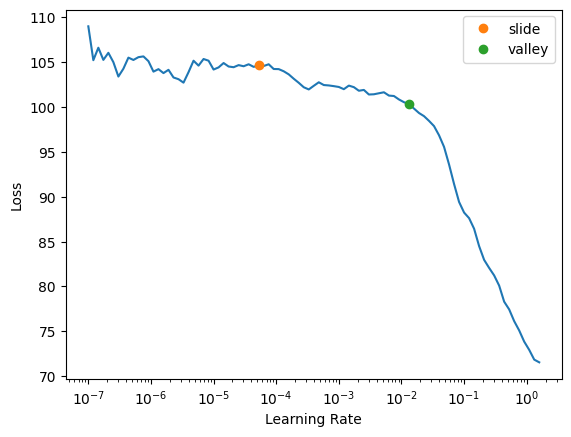

In [11]:
learn.lr_find(suggest_funcs=(slide,valley))

In [12]:
learn.fit_one_cycle(9,0.02)

epoch,train_loss,valid_loss,_rmse,time
0,4.097731,3.804876,1.950609,00:11
1,4.125066,4.458677,2.111558,00:11
2,3.900883,3.776759,1.943388,00:11
3,4.155257,3.739892,1.933880,00:11
4,4.055475,7.763447,2.786297,00:11
5,3.818873,10.323340,3.212996,00:11
6,3.696500,4330.093750,65.803429,00:11
7,3.671156,25540.332031,159.813416,00:11
8,3.769160,116314.843750,341.049652,00:11


In [ ]:
learn.show_results()

In [ ]:
dl = learn.dls.test_dl(test_df)

In [ ]:
nn_preds = learn.get_preds(dl=dl)

In [ ]:
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

In [ ]:
nn_preds_y.shape

torch.Size([60411])

In [ ]:
nn_preds_x = learn.get_preds()[0]

In [ ]:
nn_preds_x.shape

torch.Size([18123, 1])

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

2.480498

####Neural Network without id column

In [ ]:
target_preds = nn_preds[0]

test_df['Rings'] = target_preds

test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!ls

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Sub 7 with no id and sex column "

###Neural Network Ensemble

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
dl = learn.dls.test_dl(test_df)

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=rmse)
    with learn.no_bar(),learn.no_logging(): learn.fit(9, slice(1e-1,1e-3))
    return learn.get_preds(dl=dl)[0]

In [ ]:
learns = [ensemble() for _ in range(5)]

TypeError: Exception occured in `Recorder` when calling event `after_batch`:
	'numpy.float32' object is not callable

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
ens_preds, _ = learn.get_preds(dl=dl)

In [ ]:
ens_preds_y = ens_preds.squeeze(1)
ens_preds_y

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

In [ ]:
ens_preds_y[0]

In [ ]:
#target_preds = ens_preds_y[0]

#test_df['Rings'] = target_preds

#test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

#submission = pd.read_csv('submission.csv')
#submission.head()

In [ ]:
target_preds = ens_preds_y

test_df['Rings'] = target_preds

test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!ls

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network ensemble preds Sub 2 with no id column + no random seed "

In [ ]:
submission = pd.DataFrame({
     # Assuming 'Id' is the identifier column
    'target': ens_preds
})

# Save your submission to a CSV file
submission.to_csv('submission.csv', index=False)

In [ ]:
def subm(preds, suff):
    test_df['Rings'] = preds
    sub_df = test_df[['id','Rings']]
    sub_df.to_csv(f'sub{suff}.csv', index=False)

subm(ens_preds, 'mission')

In [ ]:
#sub_df = pd.DataFrame(ens_preds, columns='Rings')
#sub_df['id'] = test_df['id']

# Reorder the columns to match the submission format
#sub_df = sub_df[['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

# Save the submission DataFrame as a CSV file
#sub_df.to_csv('rf_submission.csv', index=False)

In [ ]:
#targets ='Rings'
#test_df[targets] = ens_preds
#sub_df['id'] = test_df['id']

#test_df.to_csv('submission.csv', columns=['Rings'], index=False)

#ens_sub = pd.read_csv('submission.csv')
#ens_sub.head()

### Random Forest

In [ ]:
!ls

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

In [ ]:
mse = mean_absolute_error(y_test, rf.predict(X_test))
rmse = np.sqrt(mse)
rmse

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

In [ ]:
#rf_preds = rf.predict(X_test)

In [ ]:
#rmse(rf_preds, tensor(y_test))

#### Feature Importance

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
rf_feat_importance(rf, X_train)

In [ ]:
fi = rf_feat_importance(rf, X_train)
fi[:10]

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [ ]:
pd.DataFrame(dict(cols=X_train.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

In [ ]:
fi = rf_feat_importance(rf, X_train)
fi[:10]

#### Remove low importance variables

In [ ]:
to_keep = fi[fi.imp>0.05].cols
len(to_keep)


In [ ]:
to_keep

In [ ]:
X_imp = X_train[to_keep]
X_test_new = X_test[to_keep]

In [ ]:
rf.fit(X_imp, y_train);
#m = rf(X_imp, y)

In [ ]:
rf_preds = rf.predict(X_test_new)

In [ ]:
mse = mean_absolute_error(y_test, rf.predict(X_test_new))
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
#rf_preds = rf.predict(X_test_new)
#rmse(rf_preds, tensor(y_test))

In [ ]:
X_test

In [ ]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(rf, X_train)

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

to_keep = fi[fi.imp>0.005].cols

In [ ]:
X_test_new


Shell weight and Whole weight seem to be the most importatant features closely followed by Whole Weight. 1 And Whole Weight. 2.

Sex seems to be the least important predictor.

In [ ]:
# Training dataset
numeric_columns_train = X_train.select_dtypes(include=np.number)
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.2f', mask=mask_train, cmap='Spectral', cbar=None, linewidth=2)
plt.tight_layout()
plt.show()

Darker Colors: Indicate stronger correlations. The closer the color is to the maximum intensity (e.g., red or orange for positive correlations, blue or green for negative correlations), the stronger the correlation 1.


Lighter Colors: Indicate weaker correlations. The closer the color is to the minimum intensity (e.g., white or light blue), the weaker the correlation 1.

Try dropping sex column.
or Diameter
or diameter and whole weight

In [ ]:
from fastai.tabular.all import cluster_columns

In [ ]:
cluster_columns(xs_imp)

####  Making Predictions

In [ ]:
dls = to.dataloaders(bs=64)

In [ ]:
!ls

In [ ]:
test_dl = dls.test_dl(test_df)

In [ ]:
preds = tensor(rf.predict(test_dl.xs))
rf_preds = preds

In [ ]:
#rmse(rf_preds, tensor(y_test))

Kaggle submission code from


https://www.kaggle.com/code/nguyncaoduy/fastai-tabular-regression-model-nn-xgb



In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = rf_preds # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!rm submission.csv

In [ ]:
!ls

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "random forest initial subm trial 3 with no id column in general model nb"

### XGBoost

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
#model = xgb.XGBRegressor(n_estimators = 500, max_depth=8, learning_rate=0.1, subsample=0.5)
model = xgb.XGBRegressor(n_estimators = 200, max_depth=6, learning_rate=0.15, subsample=0.5)

In [ ]:
xgb_model = model.fit(X_train, y_train)

XGBoost Feature Importance

In [ ]:
plot_importance(xgb_model);

Similar to the random forest, sex seems to be the least important predictor.
Length seems to be the only differing facotr factor from the Random forst in importance.

In [ ]:
#xgb_preds = tensor(model.predict(X_test))

In [ ]:
#rmse(xgb_preds, tensor(y_test))

In [ ]:
dls = to.dataloaders(bs=64)

In [ ]:
test_dl = dls.test_dl(test_df)

In [ ]:
X_train

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
3617,3,0.408608,1.004508,1.562373,0.745651,0.487511,0.688335,1.264194
58814,3,0.408608,0.292191,-0.139360,0.081281,0.133318,-0.030234,-0.002877
6559,3,0.492983,0.648350,0.646055,0.567539,-0.057214,0.460375,0.649857
28640,3,-1.827344,-1.844759,-1.055678,-1.438682,-1.276128,-1.452503,-1.469609
8726,3,0.324232,0.597470,1.300568,0.713962,0.414230,-0.099613,0.496272
...,...,...,...,...,...,...,...,...
55385,2,-1.236715,-1.081562,-0.924775,-1.232159,-1.266357,-1.125431,-1.077968
3869,1,0.155481,0.088672,0.646055,0.168698,0.465527,0.153125,-0.079669
52469,2,0.492983,0.495710,0.384250,0.168698,0.450871,0.177904,-0.064311


In [ ]:
preds = tensor(model.predict(test_dl.xs))
xgb_preds = preds

rmse with train set with sex column removed.

In [ ]:
xgb_preds

tensor([ 9.5830,  9.6293, 10.2743,  ..., 13.9836, 14.0047,  8.6942])

In [ ]:
mse = mean_absolute_error(y_test, model.predict(X_test))
rmse = np.sqrt(mse)
rmse

1.1190703

In [ ]:
!ls

XGBoost Submission code

In [ ]:
X_train

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = xgb_preds # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [14]:
!ls

models	sample_data


In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [11]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
model = xgb.XGBRegressor(n_estimators = 200, max_depth=6, learning_rate=0.15, subsample=0.5)
xgb_model = model.fit(X_train, y_train)
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)
preds = tensor(model.predict(test_dl.xs))
xgb_preds = preds
#submit = pd.read_csv(path/'sample_submission.csv')
#submit['Rings'] = xgb_preds
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
mse = mean_absolute_error(y_test, model.predict(X_test))
rmse = np.sqrt(mse)
rmse

1.118662

In [23]:
!ls

kaggle.json  models  sample_data


In [20]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost 19th"

100% 963k/963k [00:03<00:00, 297kB/s]
Successfully submitted to Regression with an Abalone Dataset

LightGBM

In [12]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

new_model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.1, n_estimators=200)
lgb_model = new_model.fit(X_train, y_train)

#dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_df)

new_preds = tensor(new_model.predict(test_dl.xs))
lgb_preds = new_preds


#submit = pd.read_csv(path/'sample_submission.csv')
#submit['Rings'] = xgb_preds
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
mse = mean_absolute_error(y_test, new_model.predict(X_test))
rmse = np.sqrt(mse)
rmse

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1331
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 8
[LightGBM] [Info] Start training from score 9.698877


1.1132611634613117

In [13]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = lgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [14]:
!ls

kaggle.json  sample_data  submission.csv


In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = lgb_preds # nn_preds
submit.head()

,id,Rings
0,90615,9.785251
1,90616,9.757360
2,90617,10.420464
3,90618,10.147084
4,90619,7.559184


In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!ls

sample_data  submission.csv


In [ ]:
lgb_preds.shape

torch.Size([60411])

In [ ]:
xgb_preds.shape

torch.Size([60411])

In [ ]:
mse = mean_absolute_error(y_test, model.predict(X_test))
rmse = np.sqrt(mse)
rmse

1.116810002158394

In [ ]:
# Next, install the Kaggle API client.
#!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rubanzasilva","key":"66f0a218409548d928d5c5094786660c"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

# List available datasets.
#!kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [15]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "lgb preds"

100% 962k/962k [00:01<00:00, 720kB/s]
Successfully submitted to Regression with an Abalone Dataset

###General Model Ensemble

XGBoost + Random Forest

In [ ]:
avgs = (xgb_preds + rf_preds) / 2

In [ ]:
avgs = (xgb_preds + nn_preds_y) / 2

In [16]:
lgb_xgb = (xgb_preds + lgb_preds)/2
lgb_xgb

tensor([ 9.7897,  9.4805, 10.0202,  ..., 12.4218, 12.8043,  8.6446])

In [ ]:
lgb_preds.shape

torch.Size([60411])

In [ ]:
avgs

In [ ]:
xgb_preds.shape,rf_preds.shape,nn_preds_y.shape

In [ ]:
avgs = (xgb_preds + nn_preds_y + rf_preds) / 3

In [ ]:
ens_preds_y

In [ ]:
avgs_ens = (xgb_preds + ens_preds_y + rf_preds) / 3

avgs_ens submission

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = avgs_ens # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!ls

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [ ]:
avgs.shape

In [ ]:
!ls

avgs submission

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = avgs # nn_preds
submit.head()

In [19]:
!ls

kaggle.json  sample_data


In [20]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = lgb_xgb
submit.head()

,id,Rings
0,90615,9.789662
1,90616,9.480483
2,90617,10.020164
3,90618,10.147389
4,90619,7.576179


In [21]:
submit.to_csv('submission.csv', index=False)

In [22]:
!ls

kaggle.json  sample_data  submission.csv


In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

,id,Rings
0,90615,9.785251
1,90616,9.757359
2,90617,10.420464
3,90618,10.147084
4,90619,7.559184


In [23]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "lgb preds + xgb_preds "

100% 963k/963k [00:01<00:00, 735kB/s] 
Successfully submitted to Regression with an Abalone Dataset

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost preds, nn_preds sub 1 with no id column all adjustment to test set preds"

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost preds, nn_preds + random forest preds sub 3 with no id column all adjustment to test set preds"